In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
import pickle
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [4]:
def split_train_oot(data):
    # –ù–∞—Ö–æ–¥–∏–º —Å–∞–º—É—é –ø–æ–∑–¥–Ω—é—é –¥–∞—Ç—É –≤ –¥–∞–Ω–Ω—ã—Ö
    latest_date = data['report_date'].max()

    # –í—ã—á–∏—Å–ª—è–µ–º –¥–∞—Ç—É, –∫–æ—Ç–æ—Ä–∞—è –±—ã–ª–∞ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞ –Ω–∞–∑–∞–¥ –æ—Ç —Å–∞–º–æ–π –ø–æ–∑–¥–Ω–µ–π –¥–∞—Ç—ã
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # –û—Ç–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ report_date –ø–æ–ø–∞–¥–∞–µ—Ç –≤ –ø–æ—Å–ª–µ–¥–Ω–∏–µ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # –¢–µ–ø–µ—Ä—å –∑–∞–ø–æ–ª–Ω–∏–º NaN –∑–Ω–∞—á–µ–Ω–∏—è –≤ —Å—Ç–æ–ª–±—Ü–µ 'split_type' –∑–Ω–∞—á–µ–Ω–∏–µ–º 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [5]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –≤—Å–µ—Ö –º–µ—Ç—Ä–∏–∫
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [6]:
def shap_gr(name_model, values):# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É —Å —Ä–µ–≥—É–ª–∏—Ä—É–µ–º—ã–º –º–µ—Å—Ç–æ–º –¥–ª—è —à–∫–∞–ª—ã
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≥—Ä–∞—Ñ–∏–∫–∞
    ax1.set_title("–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ SHAP –∑–Ω–∞—á–µ–Ω–∏—è–º", fontsize=14, pad=20)
    ax1.set_xlabel("–í–ª–∏—è–Ω–∏–µ –Ω–∞ –≤—ã—Ö–æ–¥ –º–æ–¥–µ–ª–∏ (SHAP value)", fontsize=12)
    ax1.set_ylabel("–ü—Ä–∏–∑–Ω–∞–∫–∏", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [236]:
df = pd.read_csv('–¥–ª—è —Ä–µ–≥—Ä–µ—Å—Å–∏–∏.csv', parse_dates=['report_date'])
cat = df.copy()
cat=cat[(cat['target_area'].notnull()) & (cat['target_cost'].notnull())].reset_index(drop=True)
cat.shape[0]

7065

In [237]:
cat = split_train_oot(cat)

In [238]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å elasticity
with open('model_elasticity_linear_zero.pkl', 'rb') as f:
    model_elasticity = pickle.load(f)
# –∑–∞–≥—Ä—É–∑–∏–º —Ñ–∏—á–∏
with open('features_model_elasticity_linear_zero.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —Å–ø–∏—Å–∫–æ–≤ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols = config.get('numeric_columns', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols

In [239]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

expon_cost__g_building__pc_cost_diff_rel__min__6M  \
0                                           0.007264   
1                                           0.007264   
2                                          -0.050003   
3                                          -0.050003   
4                                          -0.050003   

   expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1M  \
0                                          -0.003000            
1                                          -0.003000            
2                                          -0.050003            
3                                           0.003000            
4                                           0.030000            

   balance__g_building__rooms_2__structure  \
0                                 0.382389   
1                                 0.376517   
2                                 0.348872   
3                                 0.319651   
4                                 0.318048   

   expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__1_4M  \
0                                          -0.018003                  
1                                          -0.018003                  
2                                          -0.018003                  
3                                          -0.050003                  
4                                          -0.050003                  

   expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1_4M  \
0                                          -0.016665              
1                                          -0.016665              
2                                          -0.016665              
3                                          -0.050003              
4                                          -0.050003              

   expon_cost__g_building__pc_cost_diff_rel__max__1_7M  \
0                                           0.007264     
1                                           0.007264     
2                                           0.027715     
3                                           0.030000     
4                                           0.030006     

   area__g_building__smt_projected_total_area__fintech_reservation__count  \
0                                                0.0                        
1                                                0.0                        
2                                                0.0                        
3                                                0.0                        
4                                                0.0                        

   expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__1_2M  \
0                                      -2.999984e-03                  
1                                      -2.999984e-03                  
2                                      -2.999984e-03                  
3                                      -5.000295e-02                  
4                                       9.091413e-07                  

   expon_cost__g_building__pc_cost_diff_rel__rooms_2__min__6M  \
0                                          -0.036735            
1                                          -0.036735            
2                                          -0.050003            
3                                          -0.050003            
4                                          -0.050003            

   expon_cost__g_building__pc_cost_diff_rel__rooms_1__avg__1_7M  ...  \
0                                           0.005436             ...   
1                                           0.005436             ...   
2                                           0.005436             ...   
3                                          -0.049999             ...   
4                                          -0.004966             ...   

   expon_cost__g_building__pc_cost_diff_rel__avg__1_4M  \
0                                           0.0

In [240]:
# –ü–æ–ª—É—á–∏—Ç—å –∏–º–µ–Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, –Ω–∞ –∫–æ—Ç–æ—Ä—ã—Ö –æ–±—É—á–∞–ª–∞—Å—å –º–æ–¥–µ–ª—å (scikit-learn >= 1.0)
feature_names = model_elasticity.feature_names_in_  

# –£–±–µ–¥–∏—Ç—å—Å—è, —á—Ç–æ –≤ –Ω–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö —Ç–µ –∂–µ —Å—Ç–æ–ª–±—Ü—ã –≤ —Ç–æ–º –∂–µ –ø–æ—Ä—è–¥–∫–µ
X_new = filtered_df[feature_names]  
elasticity_coeff = model_elasticity.predict(X_new)
cat['target_elasticity'] = elasticity_coeff

In [241]:
cat['target_area_base'] = cat['target_area'] - cat['target_elasticity']  * cat['target_cost']

In [242]:
target_ = 'target_area_base'

# –ú–æ–¥–µ–ª—å

# –¢–µ—Å—Ç 1

In [17]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_cost',
    'target_area',
    'target_elasticity',
      target_
]

In [18]:
# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = CatBoostRegressor(
    iterations=2000,
    depth=4,
    learning_rate=0.01,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_base = metrics_df

In [19]:
metrics_df_base

dataset         MAE           MSE        RMSE      MAPE      WAPE        R2  \
0   train  158.861330  71163.225731  266.764364  0.305471  0.260125  0.757285   
1    test  198.105314  92691.172485  304.452250  0.614756  0.481831  0.226207   

   mean_target   mean_pred  n_samples  
0   610.710386  571.936532       5938  
1   411.151142  506.276605       1127

# –û—Ç–±–æ—Ä —Ñ–∏—á

In [20]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –≤—Ä–µ–º–µ–Ω–∏ –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# –°–ø–∏—Å–æ–∫ –¥–ª—è —Å–±–æ—Ä–∞ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö —Ñ–∏—á –∏ –º–µ—Ç—Ä–∏–∫
features_across_splits = []
metrics_across_splits = []

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –¥–∞—Ç–µ –¥–ª—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–≥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\nüîπ –°–ø–ª–∏—Ç {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # –°–æ–∑–¥–∞–Ω–∏–µ Pool –æ–±—ä–µ–∫—Ç–æ–≤
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
    model = CatBoostRegressor(
        iterations=1000,
        depth=4,
        learning_rate=0.05,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
    model.fit(train_pool, eval_set=val_pool)
    
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏ –º–µ—Ç—Ä–∏–∫–∏
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –¥–ª—è train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –¥–ª—è validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # –û—Ç–±–æ—Ä —Ñ–∏—á–µ–π
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" –û—Ç–æ–±—Ä–∞–Ω–æ —Ñ–∏—á–µ–π: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame(metrics_across_splits)

# –§–æ—Ä–º–∞—Ç–∏—Ä—É–µ–º –¥–∞—Ç—ã 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# –ü–µ—Ä–µ—É–ø–æ—Ä—è–¥–æ—á–∏–≤–∞–µ–º —Å—Ç–æ–ª–±—Ü—ã
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# –ê–Ω–∞–ª–∏–∑ —Ñ–∏—á–µ–π
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n –ò—Ç–æ–≥–æ–≤—ã–µ —É—Å—Ç–æ–π—á–∏–≤—ã–µ —Ñ–∏—á–∏ (–≤—Å—Ç—Ä–µ—á–∞–ª–∏—Å—å >= 2 —Ä–∞–∑):")
print("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ:", len(final_features))



üîπ –°–ø–ª–∏—Ç 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 209.7996672
bestIteration = 66

Shrink model to first 67 iterations.
Feature #3 eliminated
Feature #795 eliminated
Feature #621 eliminated
Feature #889 eliminated
Feature #132 eliminated
Feature #1046 eliminated
Feature #28 eliminated
Feature #25 eliminated
Feature #952 eliminated
Feature #295 eliminated
Feature #743 eliminated
Feature #108 eliminated
Feature #1034 eliminated
Feature #867 eliminated
Feature #513 eliminated
Feature #773 eliminated
Feature #543 eliminated
Feature #630 eliminated
Feature #1042 eliminated
Feature #142 eliminated
Feature #334 eliminated
Feature #165 eliminated
Feature #49 eliminated
Feature #303 eliminated
Feature #819 eliminated
Feature #968 eliminated
Feature #986 eliminated
Feature #518 eliminated
Feature #100 eliminated
Feature #174 eliminated
Feature #136 eliminated
Feature #413 eliminated
Feature #192 elim

In [21]:
metrics_df_select_features

split  start_date    end_date  n_samples  mean_target   mean_pred  \
0  fold_1_train  2022-03-01  2022-09-01        993   665.591160  584.061509   
1    fold_1_val  2022-09-01  2023-03-01        989   548.699151  537.979779   
2  fold_2_train  2022-03-01  2023-03-01       1982   607.263109  573.049498   
3    fold_2_val  2023-03-01  2023-08-01        989   553.463241  522.491902   
4  fold_3_train  2022-03-01  2023-08-01       2971   589.353964  557.491779   
5    fold_3_val  2023-08-01  2023-12-01        989   728.024112  601.937713   
6  fold_4_train  2022-03-01  2023-12-01       3960   623.986483  542.086016   
7    fold_4_val  2023-12-01  2024-03-01        989   552.966570  598.947618   
8  fold_5_train  2022-03-01  2024-03-01       4949   609.793981  577.893435   
9    fold_5_val  2024-03-01  2024-06-01        989   615.296118  494.198228   

          mae        rmse      mape      wape        r2  
0  188.675881  359.218416  0.331006  0.283471  0.630966  
1  211.679971  330.973286  0.509885  0.385785  0.478492  
2   88.194636  189.250037  0.162900  0.145233  0.873628  
3  183.963224  276.161276  0.421092  0.332386  0.657179  
4  101.295311  199.734335  0.196600  0.171875  0.848754  
5  232.579333  389.591076  0.348304  0.319467  0.649596  
6  208.589541  370.035788  0.389001  0.334285  0.557840  
7  237.880703  366.336208  0.593367  0.430190  0.477164  
8  116.770120  219.997585  0.221637  0.191491  0.838612  
9  211.019345  329.320611  0.352097  0.342956  0.582342

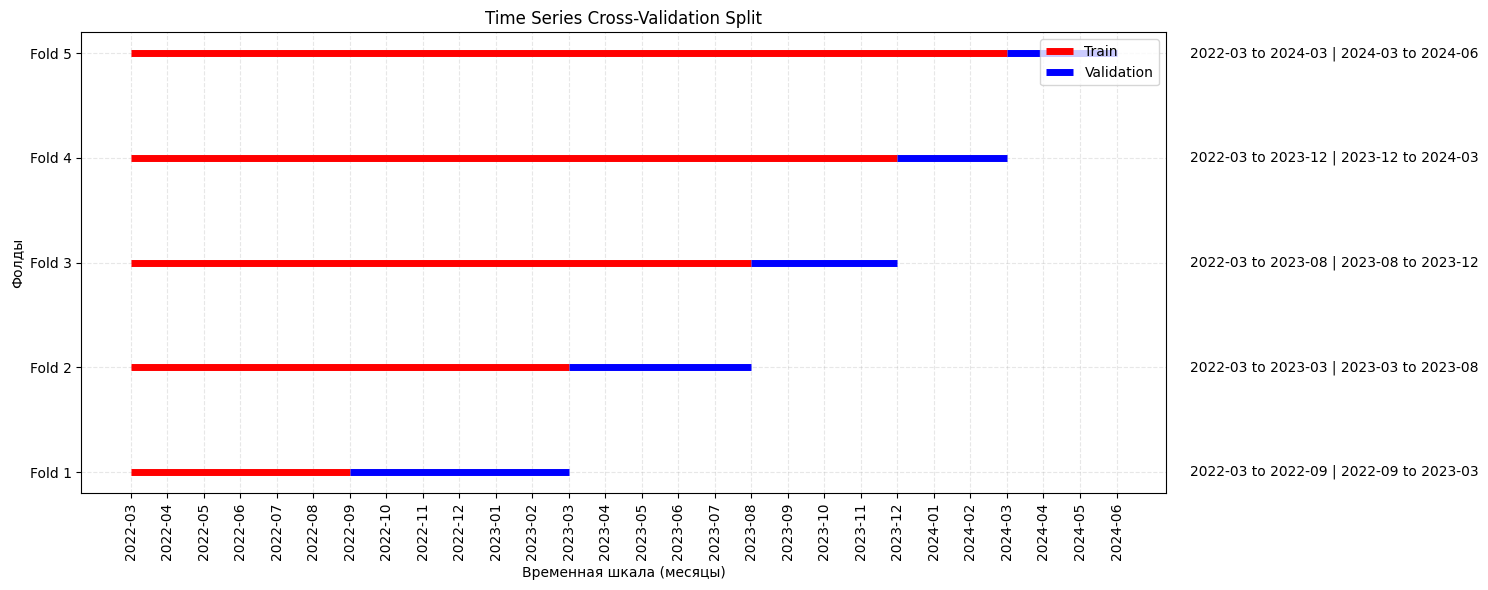

In [22]:
plt.figure(figsize=(15, 6))

# –ü–æ–ª—É—á–∞–µ–º –≤—Å–µ —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –¥–∞—Ç—ã
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # –§–æ—Ä–º–∞—Ç YYYY-MM

# –¶–≤–µ—Ç–∞ –¥–ª—è train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # –ù–∞—Ö–æ–¥–∏–º –∏–Ω–¥–µ–∫—Å—ã –¥–∞—Ç
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # –†–∏—Å—É–µ–º –ª–∏–Ω–∏–∏
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('–í—Ä–µ–º–µ–Ω–Ω–∞—è —à–∫–∞–ª–∞ (–º–µ—Å—è—Ü—ã)')
plt.ylabel('–§–æ–ª–¥—ã')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# –î–æ–±–∞–≤–∏–º –ø–æ–¥–ø–∏—Å–∏ –¥–∞—Ç –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ñ–æ–ª–¥–∞
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [23]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

area__g_building__smt_projected_total_area__rooms_0_str_r__count  \
0                                                0.0                  
1                                              102.0                  
2                                               92.0                  

   mortgages__g_building__application__count__6M  \
0                                            0.0   
1                                           33.0   
2                                          180.0   

   price__g_building__rooms_2__sum__1M  \
0                         4.293916e+08   
1                         2.382018e+09   
2                         1.946892e+09   

   sales__g_building__sale_price__rooms_1__sum__12M  \
0                                        99322260.0   
1                                        26425338.0   
2                                       104758230.0   

   sales__g_building__sale_cost__rooms_0__count__1M  \
0                                               0.0   
1                                               3.0   
2                                              10.0   

   area__g_building__smt_projected_total_area__rooms_2_free__sum  \
0                                          14610.101               
1                                           4503.900               
2                                           4649.000               

   sales__g_building__sale_price__sum__6M  \
0                             320840615.0   
1                             147893940.0   
2                             724442100.0   

   area__g_building__smt_projected_total_area__rooms_2_str_r__count  \
0                                                0.0                  
1                                              235.0                  
2                                              172.0                  

   area__g_building__smt_projected_total_area__free__count  \
0                                               35.0         
1                                              278.0         
2                                              280.0         

   expon_cost__g_building__pc_cost_diff__avg__3M  ...  \
0                                       1370.000  ...   
1                                       5265.000  ...   
2                                      -8702.604  ...   

   expon_cost__g_building__pc_cost_diff__rooms_2__avg__1M  \
0                                          1067.3334        
1                                          1067.3334        
2                                         -8531.4730        

   reservations__g_building__smt_projected_total_area__rooms_2__sum__1M  \
0                                                0.0                      
1                                              690.8                      
2                                                0.0                      

   area__g_building__smt_projected_total_area__count  \
0                                              883.0   
1                                              883.0   
2                                              883.0   

   expon_cost__g_building__pc_cost__rooms_2__avg__1M  \
0                                          207467.20   
1                                          170312.02   
2                                          165976.86   

   area__g_building__smt_projected_total_area__free__sum  \
0                                            1509.11       
1                                           12022.20       
2                                           12188.90       

   reservations__g_building__smt_projected_total_area__rooms_1__sum__3M  \
0                                         184.965005                      
1                                         193.900000                      
2                                         973.700000                      

   rosstat_q__g_rd__i40__avg__1_8Q  \
0                        105.23781   
1                        106.00720   
2                        108.

In [24]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("–ß–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã:", numeric_cols)
print("–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã:", categorical_cols)

–ß–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã: ['area__g_building__smt_projected_total_area__rooms_0_str_r__count', 'mortgages__g_building__application__count__6M', 'price__g_building__rooms_2__sum__1M', 'sales__g_building__sale_price__rooms_1__sum__12M', 'sales__g_building__sale_cost__rooms_0__count__1M', 'area__g_building__smt_projected_total_area__rooms_2_free__sum', 'sales__g_building__sale_price__sum__6M', 'area__g_building__smt_projected_total_area__rooms_2_str_r__count', 'area__g_building__smt_projected_total_area__free__count', 'expon_cost__g_building__pc_cost_diff__avg__3M', 'expon_cost__g_building__pc_cost_diff__avg__1M', 'price__g_building__rooms_0__sum__1M', 'expon_cost__g_building__pc_cost__avg__1M', 'area__g_building__smt_projected_total_area__sum', 'area__g_building__smt_projected_total_area__str_r__count', 'area__g_building__smt_projected_total_area__reservation_end_next_month__count', 'area__g_building__smt_projected_total_area__reserved__sum', 'reservations__g_building__smt_project

In [25]:

# –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –¥–ª—è YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'id': ['smt_building_addressid'],
    'date' : ['report_date'],
    'target' : [target_]
}

# –ó–∞–ø–∏—Å—ã–≤–∞–µ–º –≤ YAML-—Ñ–∞–π–ª
with open('features_model_final_area.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [243]:
# –∑–∞–≥—Ä—É–∑–∏–º —Ñ–∏—á–∏
with open('features_model_final_area.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —Å–ø–∏—Å–∫–æ–≤ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [244]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

area__g_building__smt_projected_total_area__rooms_0_str_r__count  \
0                                                0.0                  
1                                              102.0                  
2                                               92.0                  
3                                               78.0                  
4                                               69.0                  

   mortgages__g_building__application__count__6M  \
0                                            0.0   
1                                           33.0   
2                                          180.0   
3                                          348.0   
4                                          410.0   

   price__g_building__rooms_2__sum__1M  \
0                         4.293916e+08   
1                         2.382018e+09   
2                         1.946892e+09   
3                         1.580494e+09   
4                         1.527488e+09   

   sales__g_building__sale_price__rooms_1__sum__12M  \
0                                        99322260.0   
1                                        26425338.0   
2                                       104758230.0   
3                                       138470860.0   
4                                       173542350.0   

   sales__g_building__sale_cost__rooms_0__count__1M  \
0                                               0.0   
1                                               3.0   
2                                              10.0   
3                                               0.0   
4                                               9.0   

   area__g_building__smt_projected_total_area__rooms_2_free__sum  \
0                                         14610.1010               
1                                          4503.9000               
2                                          4649.0000               
3                                          4585.3000               
4                                          4611.3003               

   sales__g_building__sale_price__sum__6M  \
0                            3.208406e+08   
1                            1.478939e+08   
2                            7.244421e+08   
3                            1.311990e+09   
4                            1.543108e+09   

   area__g_building__smt_projected_total_area__rooms_2_str_r__count  \
0                                                0.0                  
1                                              235.0                  
2                                              172.0                  
3                                              118.0                  
4                                              106.0                  

   area__g_building__smt_projected_total_area__free__count  \
0                                               35.0         
1                                              278.0         
2                                              280.0         
3                                              273.0         
4                                              275.0         

   expon_cost__g_building__pc_cost_diff__avg__3M  ...  \
0                                      1370.0000  ...   
1                                      5265.0000  ...   
2                                     -8702.6040  ...   
3                                     -1670.6924  ...   
4                                     -1429.4852  ...   

   reservations__g_building__smt_projected_total_area__rooms_2__sum__1M  \
0                                                0.0                      
1                                              690.8                      
2                                                0.0                      
3                                                0.0                      
4                                              700.5                      

   area__g_building__smt_projected_total_area__count  \
0                 

In [245]:
filtered_df = split_train_oot(filtered_df)

# –ú–æ–¥–µ–ª—å 2 –Ω–∞ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö —Ñ–∏—á–∞—Ö

In [195]:
# –†–∞–∑–¥–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –∏ —Ç–µ—Å—Ç–æ–≤—ã–µ
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# –í—ã–±–µ—Ä–∏—Ç–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (features) –∏ —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é (target)
# –î–æ–ø—É—Å—Ç–∏–º, —É –≤–∞—Å –µ—Å—Ç—å —Å—Ç–æ–ª–±–µ—Ü 'target', –∫–æ—Ç–æ—Ä—ã–π –Ω—É–∂–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 'report_date',
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',
                         target_])  
y_test = test_data[target_]

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=4,         
                    learning_rate=0.01,  # –£–º–µ–Ω—å—à–∞–µ–º learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=3,   
                    random_strength=1,
                    early_stopping_rounds=100,  # –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞
                    verbose=200,
                    grow_policy='Lossguide'  # –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è —Å—Ç—Ä–∞—Ç–µ–≥–∏—è —Ä–æ—Å—Ç–∞
                )
# –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
model.fit(X_train, y_train)

# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_with_select_features = metrics_df

0:	learn: 358.3624072	total: 3.65ms	remaining: 7.31s
200:	learn: 216.1664985	total: 530ms	remaining: 4.75s
400:	learn: 190.5644104	total: 1.14s	remaining: 4.53s
600:	learn: 178.7423591	total: 1.66s	remaining: 3.87s
800:	learn: 171.0430263	total: 2.2s	remaining: 3.29s
1000:	learn: 164.6419993	total: 2.71s	remaining: 2.71s
1200:	learn: 158.9740309	total: 3.25s	remaining: 2.17s
1400:	learn: 154.2078076	total: 3.79s	remaining: 1.62s
1600:	learn: 149.9183375	total: 4.31s	remaining: 1.07s
1800:	learn: 146.4059584	total: 4.82s	remaining: 533ms
1999:	learn: 143.4453048	total: 5.33s	remaining: 0us


In [196]:
metrics_df_with_select_features

dataset         MAE           MSE        RMSE      MAPE      WAPE        R2  \
0   train  143.445306  58626.184743  242.128447  0.280555  0.234883  0.800045   
1    test  202.463287  90406.723016  300.677108  0.642081  0.492430  0.245278   

   mean_target   mean_pred  n_samples  
0   610.710386  573.157772       5938  
1   411.151142  527.884178       1127

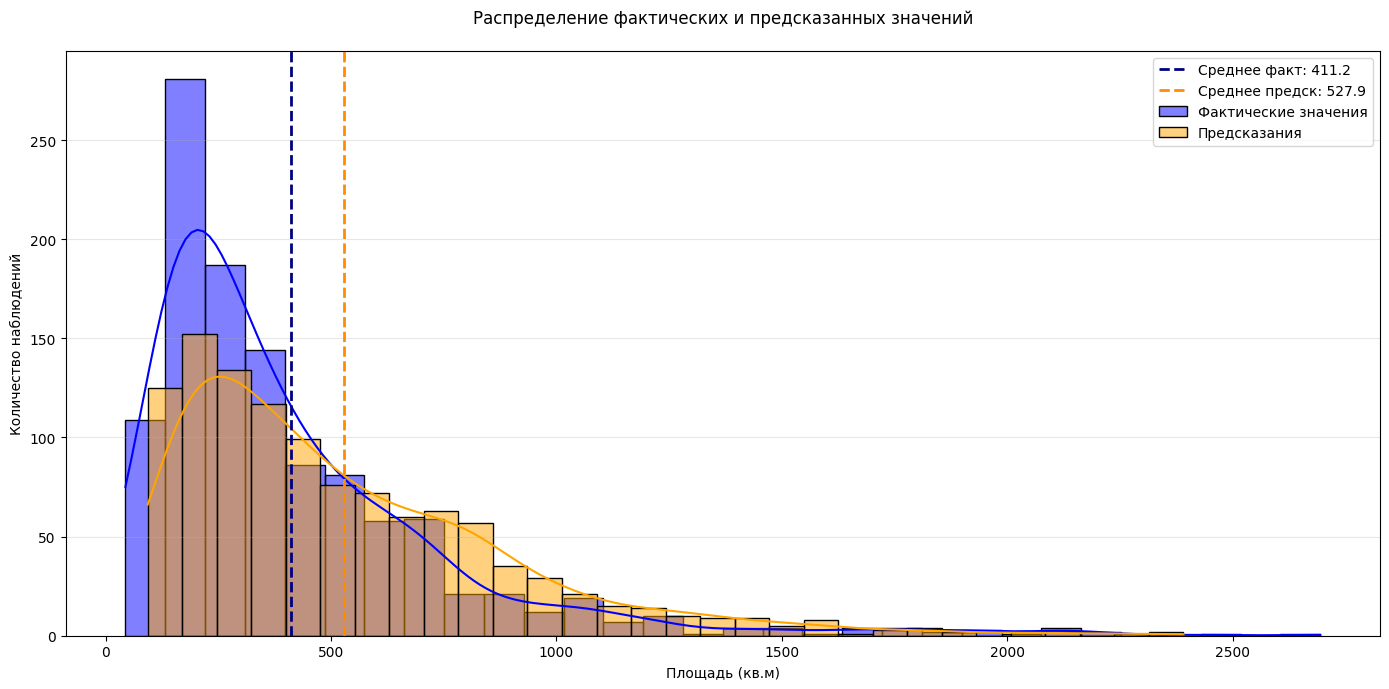

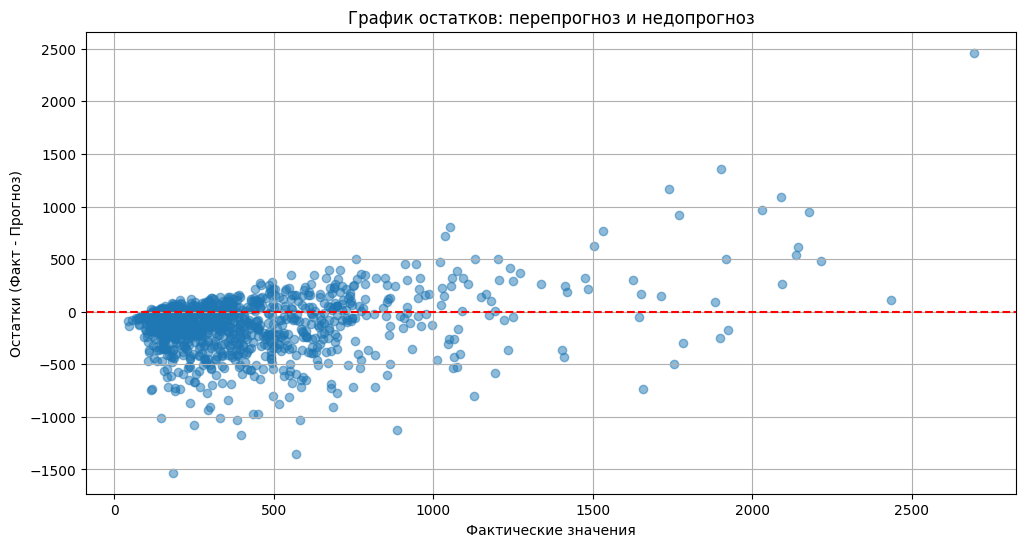

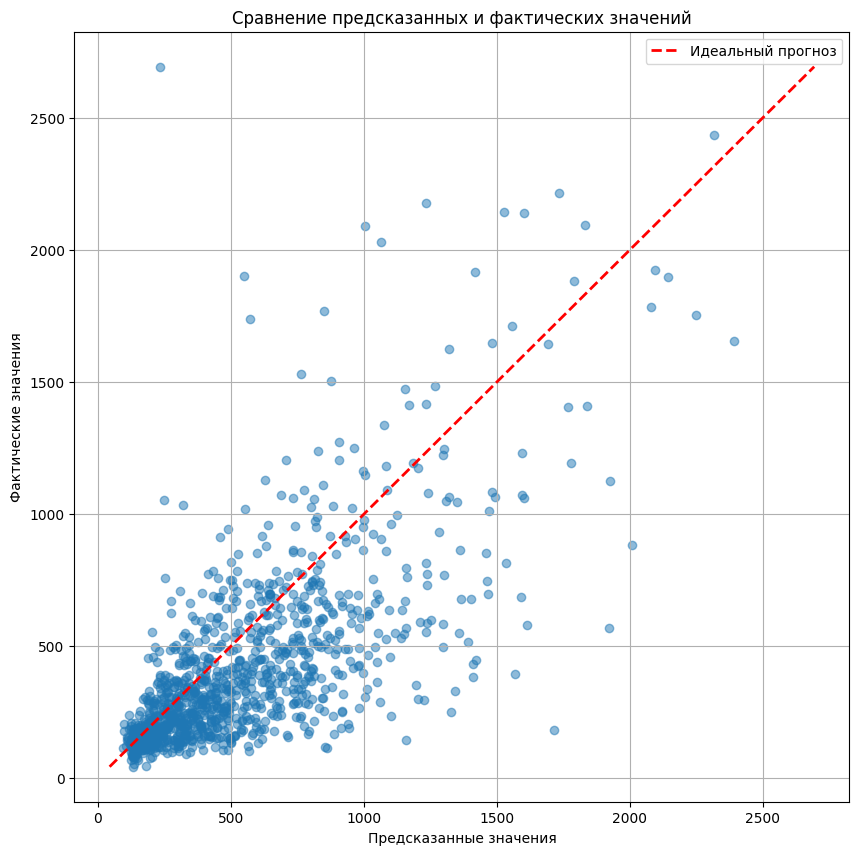

In [31]:
# 1. –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–∞—Ä–≥–µ—Ç–∞ –∏ –ø—Ä–µ–¥–∏–∫—Ç–æ–≤
plt.figure(figsize=(14, 7))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è', kde=True, ax=ax)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ —Ñ–∞–∫—Ç: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ –ø—Ä–µ–¥—Å–∫: {test_pred.mean():.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π', pad=20)
plt.xlabel('–ü–ª–æ—â–∞–¥—å (–∫–≤.–º)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. –ì—Ä–∞—Ñ–∏–∫ –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑–∞/–Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑–∞
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –æ—Å—Ç–∞—Ç–∫–æ–≤: –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑ –∏ –Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑')
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–û—Å—Ç–∞—Ç–∫–∏ (–§–∞–∫—Ç - –ü—Ä–æ–≥–Ω–æ–∑)')
plt.grid()
plt.show()

# 3. –°–∫—ç—Ç—Ç–µ—Ä–ø–ª–æ—Ç —Å –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–æ–π –ª–∏–Ω–∏–µ–π
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='–ò–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∏ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.legend()
plt.grid()
plt.show()

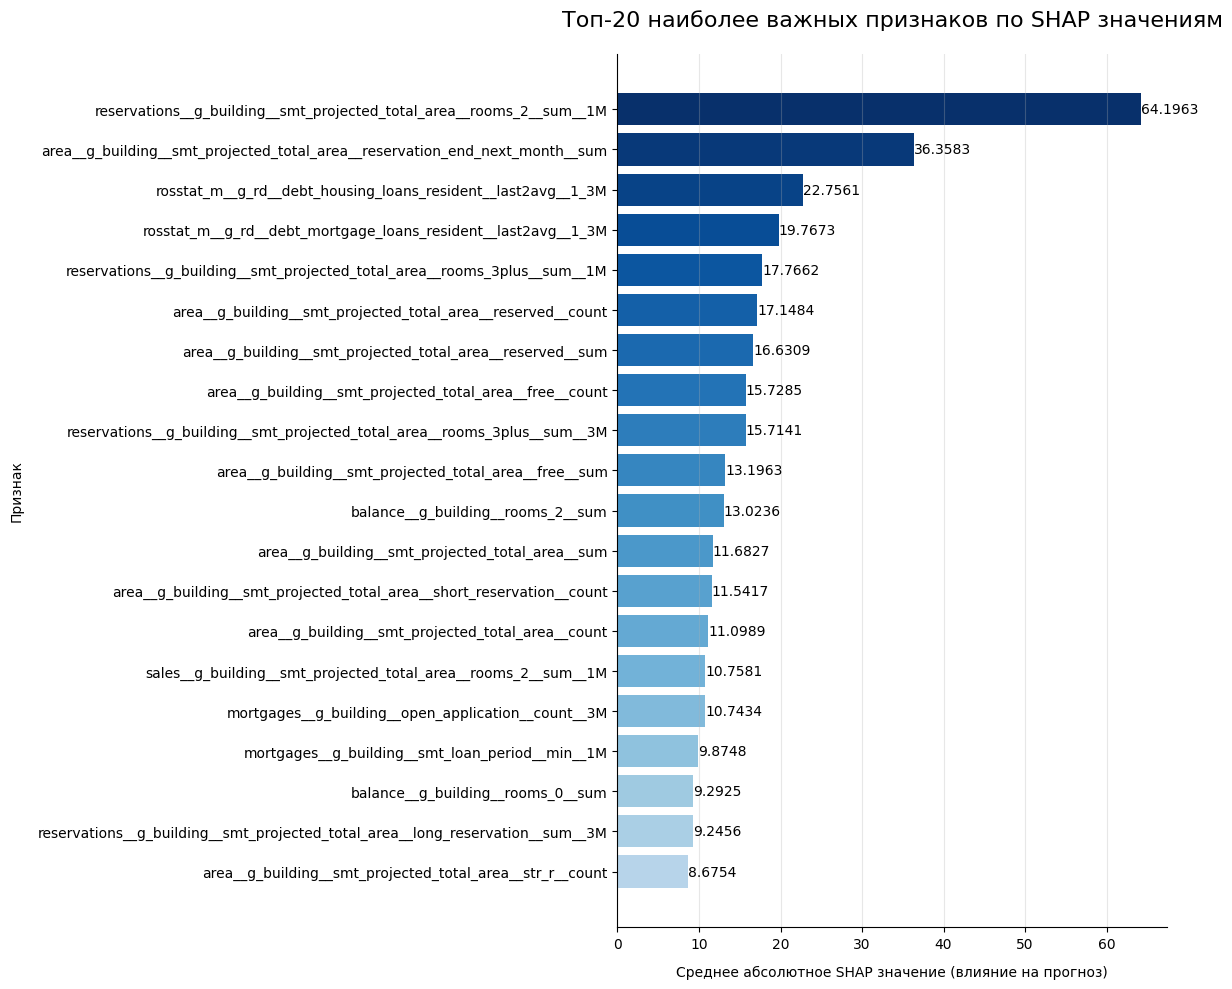

In [32]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ —Ä–∞—Å—á–µ—Ç SHAP –∑–Ω–∞—á–µ–Ω–∏–π
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –≤–∞–∂–Ω–æ—Å—Ç—å—é —Ñ–∏—á
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# –°—Ç–∏–ª–∏–∑–∞—Ü–∏—è –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(12, 10))

# –ì–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π bar plot —Å —Ü–≤–µ—Ç–æ–≤–æ–π –≥—Ä–∞–¥–∞—Ü–∏–µ–π
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≤–Ω–µ—à–Ω–µ–≥–æ –≤–∏–¥–∞
plt.title('–¢–æ–ø-20 –Ω–∞–∏–±–æ–ª–µ–µ –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ SHAP –∑–Ω–∞—á–µ–Ω–∏—è–º', pad=20, fontsize=16)
plt.xlabel('–°—Ä–µ–¥–Ω–µ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ SHAP –∑–Ω–∞—á–µ–Ω–∏–µ (–≤–ª–∏—è–Ω–∏–µ –Ω–∞ –ø—Ä–æ–≥–Ω–æ–∑)', labelpad=10)
plt.ylabel('–ü—Ä–∏–∑–Ω–∞–∫', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


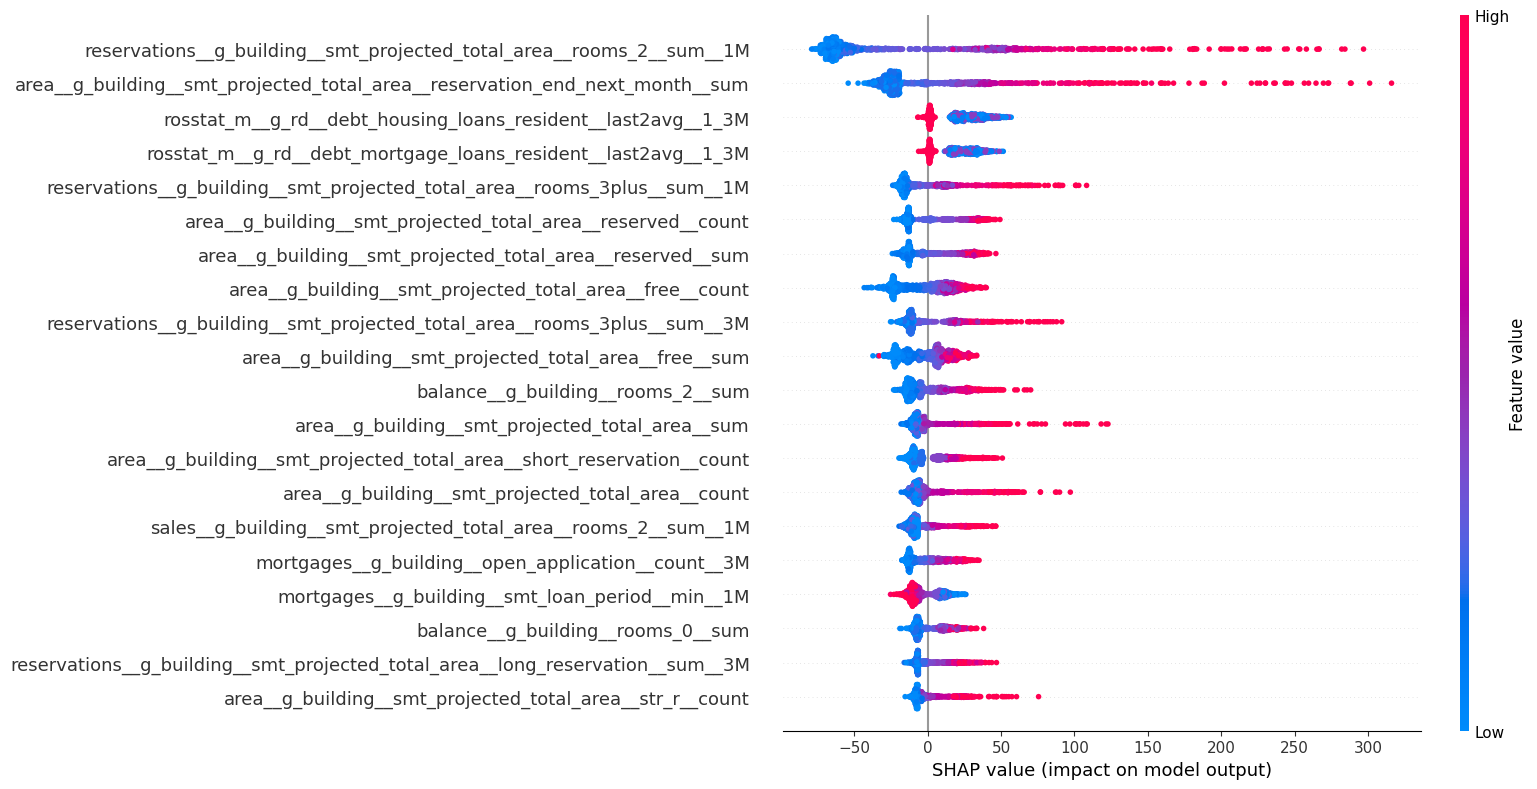

In [33]:
shap_gr(model, X_test)

# OPTUNA

In [246]:
# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date', target_])
y_test = test_data[target_]

# –î–µ–ª–∏–º —á–∞—Å—Ç—å train –Ω–∞ train/valid –¥–ª—è Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# –î–ª—è CatBoost –Ω—É–∂–Ω–æ —É–∫–∞–∑—ã–≤–∞—Ç—å cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# –£–ª—É—á—à–µ–Ω–Ω–∞—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —á–µ—Ä–µ–∑ Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # –î–æ–±–∞–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–∏–ø–∞ –±—É—Ç—Å—Ç—Ä–∞–ø–∞
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# –£–ª—É—á—à–µ–Ω–Ω—ã–π –∑–∞–ø—É—Å–∫ Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=30)  

print("–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# –û–±—É—á–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# –£–¥–∞–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ –Ω—É–∂–Ω—ã –≤ —Ñ–∏–Ω–∞–ª—å–Ω–æ–π –º–æ–¥–µ–ª–∏
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_optuna = metrics_df

[I 2025-05-21 23:38:21,588] A new study created in memory with name: no-name-6ab6650d-ead3-4689-b8fb-7463cd276558
[I 2025-05-21 23:38:24,384] Trial 0 finished with value: 175.59300836795762 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 175.59300836795762.
[I 2025-05-21 23:38:26,346] Trial 1 finished with value: 188.36905735934008 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 175.59300836795762.
[I 2025-05-21 23:38:28,827] Trial 2

–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:
iterations: 2179
depth: 7
learning_rate: 0.013450549446761025
l2_leaf_reg: 7.832430217107163
random_strength: 1.813342615712527
border_count: 111
min_data_in_leaf: 32
grow_policy: SymmetricTree
bootstrap_type: MVS
0:	learn: 357.5634002	total: 2.62ms	remaining: 2.61s
100:	learn: 227.9405471	total: 298ms	remaining: 2.65s
200:	learn: 194.5441880	total: 565ms	remaining: 2.24s
300:	learn: 179.3671204	total: 817ms	remaining: 1.9s
400:	learn: 169.1737770	total: 1.08s	remaining: 1.61s
500:	learn: 161.7499904	total: 1.33s	remaining: 1.32s
600:	learn: 155.3170963	total: 1.58s	remaining: 1.05s
700:	learn: 149.0294015	total: 1.83s	remaining: 780ms
800:	learn: 143.2598018	total: 2.09s	remaining: 519ms
900:	learn: 138.0612825	total: 2.35s	remaining: 258ms
999:	learn: 133.2751690	total: 2.6s	remaining: 0us


In [198]:
metrics_df_optuna

dataset         MAE           MSE        RMSE      MAPE      WAPE        R2  \
0   train  133.275170  47719.006404  218.446805  0.269066  0.218230  0.837246   
1    test  202.641246  90795.404984  301.322759  0.642815  0.492863  0.242033   

   mean_target   mean_pred  n_samples  
0   610.710386  576.607153       5938  
1   411.151142  527.815085       1127

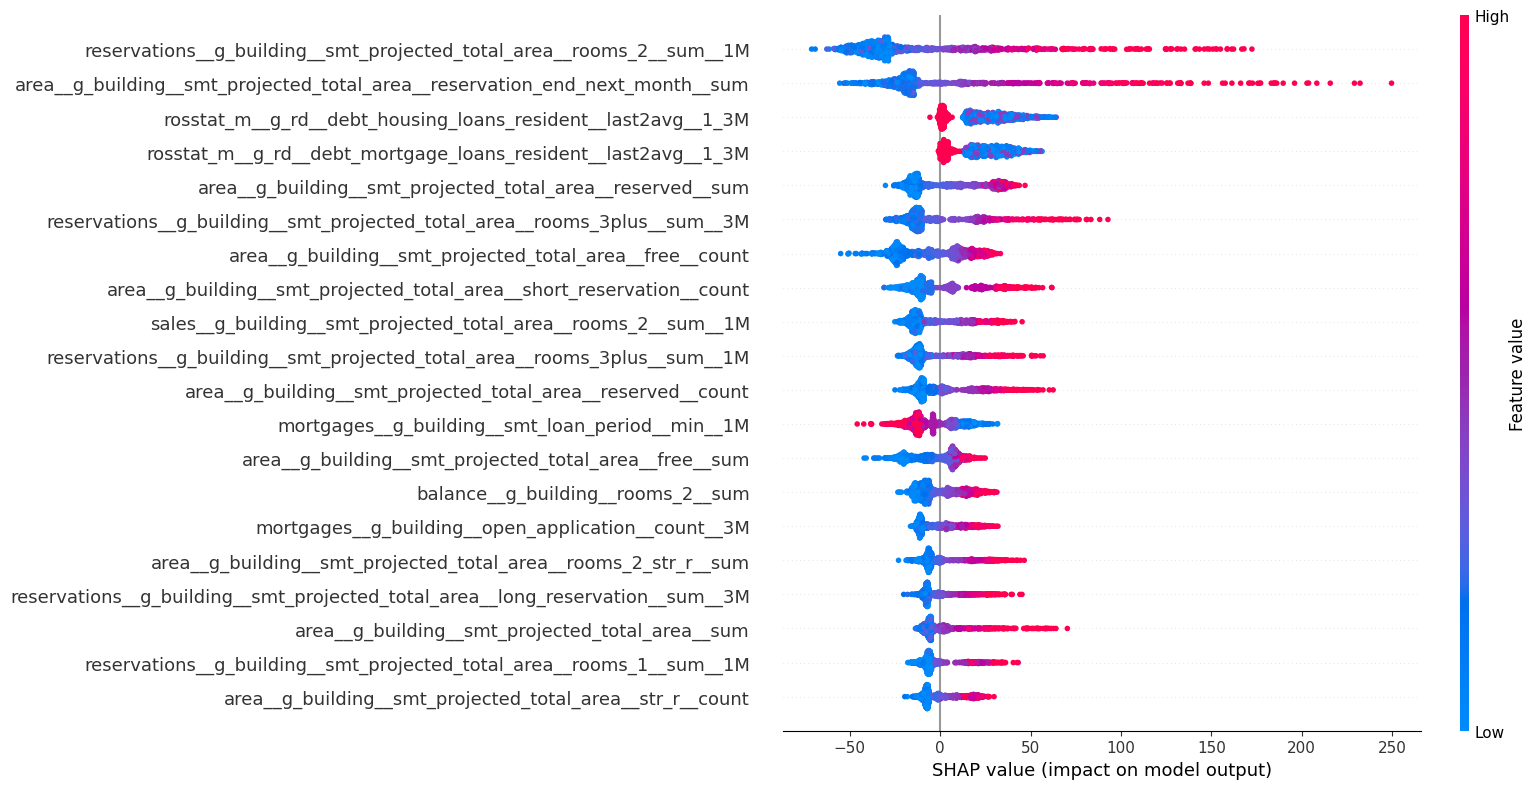

In [36]:
shap_gr(final_model, X_test)

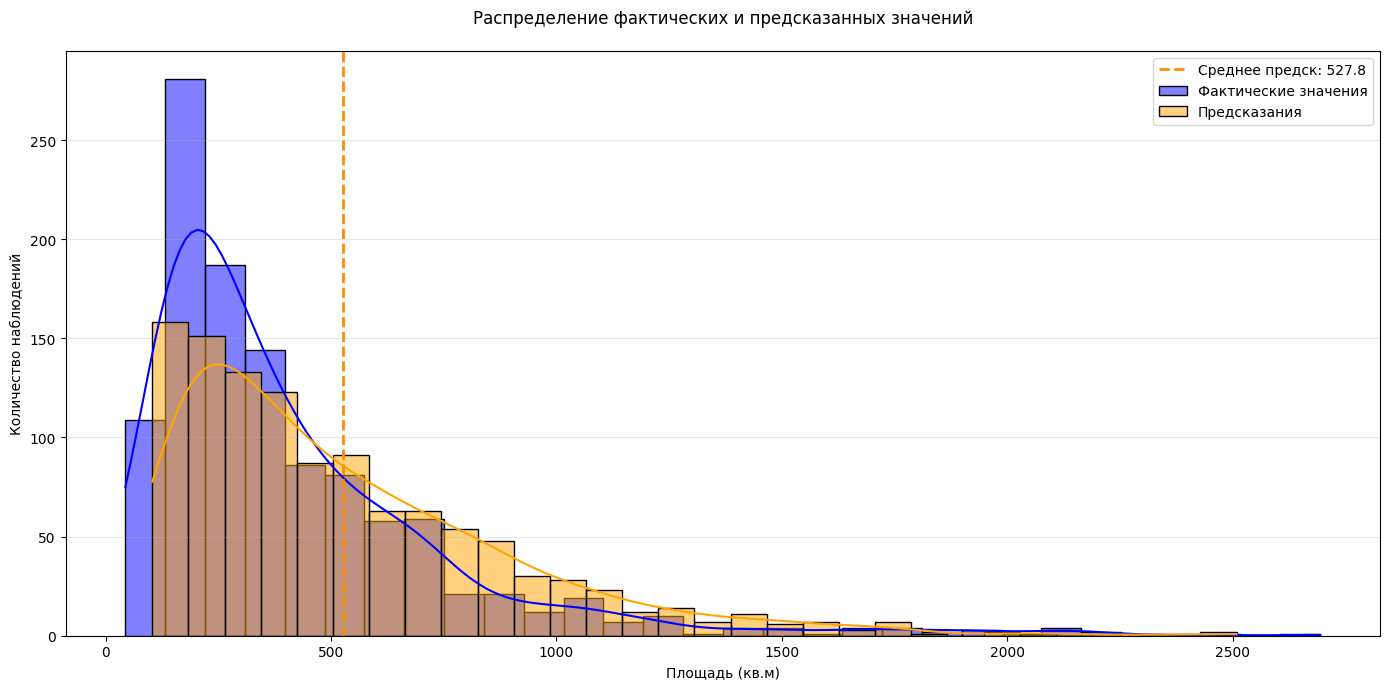

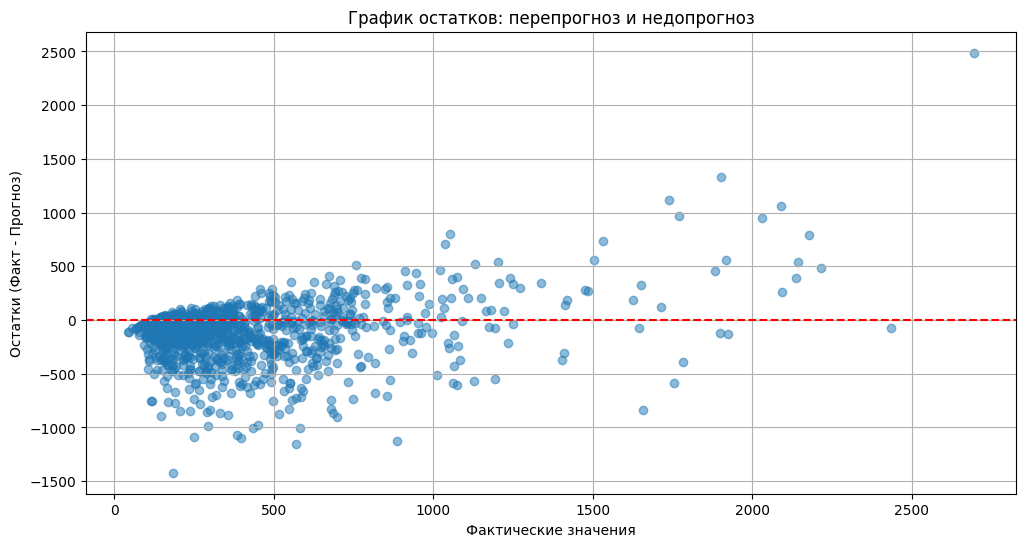

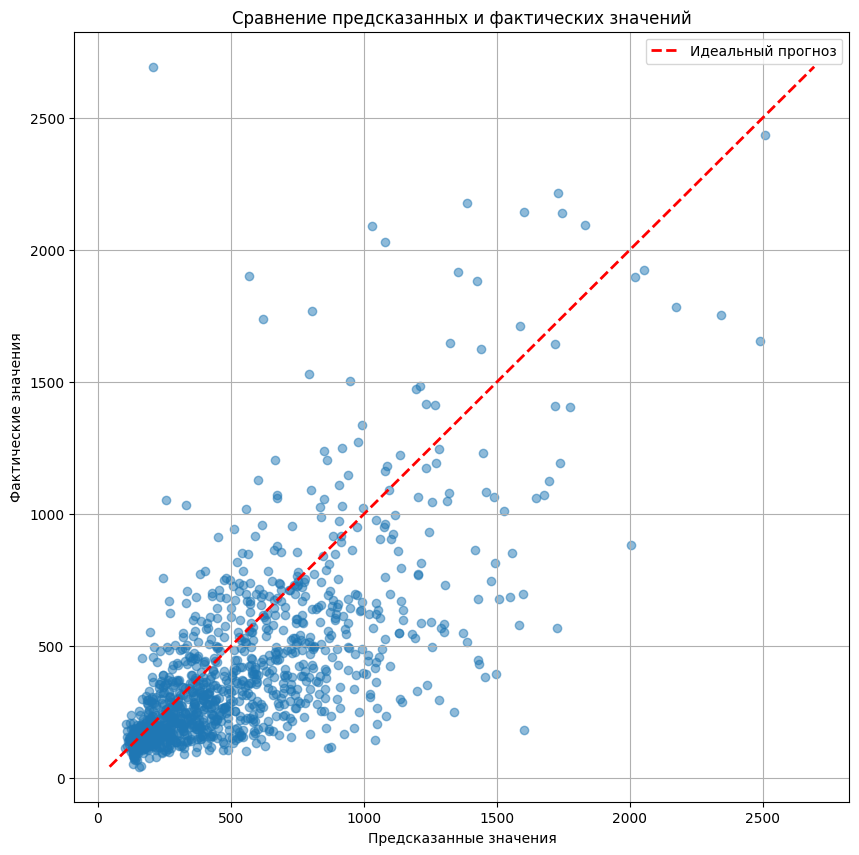

In [37]:
# 1. –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–∞—Ä–≥–µ—Ç–∞ –∏ –ø—Ä–µ–¥–∏–∫—Ç–æ–≤
plt.figure(figsize=(14, 7))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è', kde=True, ax=ax)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
# plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ —Ñ–∞–∫—Ç: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ –ø—Ä–µ–¥—Å–∫: {test_pred.mean():.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π', pad=20)
plt.xlabel('–ü–ª–æ—â–∞–¥—å (–∫–≤.–º)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. –ì—Ä–∞—Ñ–∏–∫ –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑–∞/–Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑–∞
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –æ—Å—Ç–∞—Ç–∫–æ–≤: –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑ –∏ –Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑')
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–û—Å—Ç–∞—Ç–∫–∏ (–§–∞–∫—Ç - –ü—Ä–æ–≥–Ω–æ–∑)')
plt.grid()
plt.show()

# 3. –°–∫—ç—Ç—Ç–µ—Ä–ø–ª–æ—Ç —Å –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–æ–π –ª–∏–Ω–∏–µ–π
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='–ò–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∏ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.legend()
plt.grid()
plt.show()


In [38]:
metrics_df_base.insert(0, 'stage', '–ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å')
metrics_df_with_select_features.insert(0, 'stage', '–ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
metrics_df_optuna.insert(0, 'stage', '–û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)')

In [39]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

stage dataset         MAE           MSE  \
0                    –ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å   train  158.861330  71163.225731   
1                    –ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å    test  198.105314  92691.172485   
2        –ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤   train  143.445306  58626.184743   
3        –ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤    test  202.463287  90406.723016   
4  –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)   train  133.275170  47719.006404   
5  –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)    test  202.641246  90795.404984   

         RMSE      MAPE      WAPE        R2  mean_target   mean_pred  \
0  266.764364  0.305471  0.260125  0.757285   610.710386  571.936532   
1  304.452250  0.614756  0.481831  0.226207   411.151142  506.276605   
2  242.128447  0.280555  0.234883  0.800045   610.710386  573.157772   
3  300.677108  0.642081  0.492430  0.245278   411.151142  527.884178   
4  218.446805  0.269066  0.218230  0.837246   610.710386  576.607153   
5  301.322759  0.642815  0.492863  0.242033   411.151142  527.815085   

   n_samples  
0       5938  
1       1127  
2       5938  
3       1127  
4       5938  
5       1127

In [40]:
# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–æ–¥–µ–ª—å
with open('model_final.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# –ì—Ä–∞—Ñ–∏–∫–∏

In [43]:
base = test_pred
coeff = cat[cat['split_type']=='oot']['target_elasticity']
cost = cat[cat['split_type']=='oot']['target_cost']

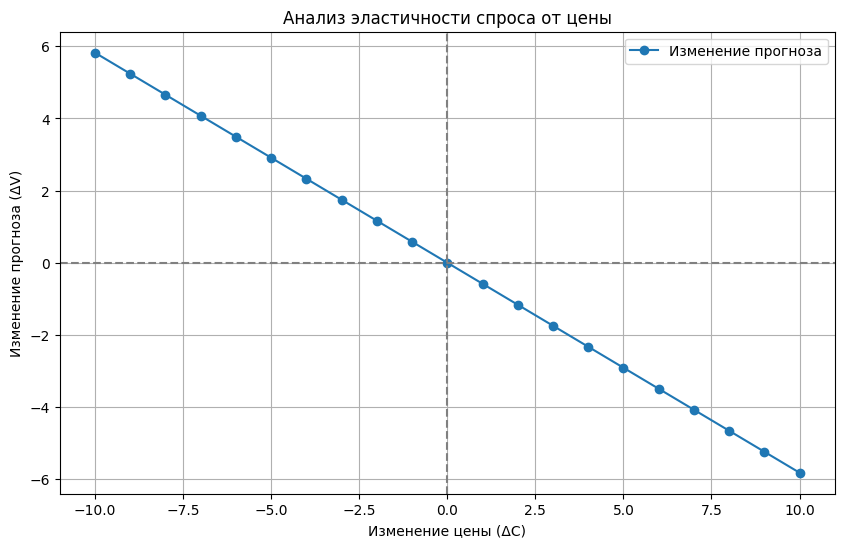

In [45]:
# 1. –ë–∞–∑–æ–≤—ã–π –ø—Ä–æ–≥–Ω–æ–∑ (–±–µ–∑ —É—á–µ—Ç–∞ –∏–∑–º–µ–Ω–µ–Ω–∏–π —Ü–µ–Ω—ã)
V_pred_0 = base+coeff * cost

# 2. –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
results = []

for alpha in np.arange(-0.1, 0.101, 0.01):
    # –ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ —Ü–µ–Ω—ã
    modified_pred = base +coeff * (cost * (1+alpha))
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º ŒîV –∏ ŒîC
    delta_V = ((modified_pred - V_pred_0) / V_pred_0)
    delta_C = alpha
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
    results.append({
        'alpha': alpha,
        'delta_C': delta_C*100,
        'delta_V_mean': np.mean(delta_V*100),
        'delta_V': delta_V
    })

# 3. –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
results_df = pd.DataFrame(results)

# –ì—Ä–∞—Ñ–∏–∫
plt.figure(figsize=(10, 6))
plt.plot(results_df['delta_C'], results_df['delta_V_mean'], 'o-', label='–ò–∑–º–µ–Ω–µ–Ω–∏–µ –ø—Ä–æ–≥–Ω–æ–∑–∞')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('–ò–∑–º–µ–Ω–µ–Ω–∏–µ —Ü–µ–Ω—ã (ŒîC)')
plt.ylabel('–ò–∑–º–µ–Ω–µ–Ω–∏–µ –ø—Ä–æ–≥–Ω–æ–∑–∞ (ŒîV)')
plt.title('–ê–Ω–∞–ª–∏–∑ —ç–ª–∞—Å—Ç–∏—á–Ω–æ—Å—Ç–∏ —Å–ø—Ä–æ—Å–∞ –æ—Ç —Ü–µ–Ω—ã')
plt.legend()
plt.grid(True)
plt.show()

In [247]:
drop_cols = [
'split_type', 'smt_building_addressid', 'report_date','target_area_base','target_cost','elast_predicted'
]

In [248]:
plot_df = filtered_df.copy()

In [249]:
final_pred =final_model.predict(filtered_df.drop(columns=['smt_building_addressid', 'split_type', 'report_date', target_ ]))
plot_df['target_cost'] = cat['target_cost']
plot_df['elast_predicted'] = elasticity_coeff

In [250]:
plot_df['final_area'] = final_pred + plot_df['elast_predicted'] *plot_df['target_cost'] 

In [251]:
plot_df['target_area'] = cat['target_area'] 

In [279]:
for_lin = plot_df.groupby(['report_date', 'split_type'], as_index=False).agg({'target_area':'mean',
                                                                    'final_area':'mean'
                                                                    }).rename(columns={'target_area':'mean_target',
                                                                               'final_area':'mean_predict'})
for_lin

report_date split_type  mean_target  mean_predict
0   2022-03-01      train   665.991606    594.734157
1   2022-04-01      train   499.400473    508.231918
2   2022-05-01      train   557.417557    530.992402
3   2022-06-01      train   532.989730    496.814375
4   2022-07-01      train   629.758672    564.247765
5   2022-08-01      train   707.602533    638.159473
6   2022-09-01      train   502.754839    561.032324
7   2022-10-01      train   465.177823    469.510727
8   2022-11-01      train   526.758324    463.760319
9   2022-12-01      train   550.963390    476.060861
10  2023-01-01      train   340.817241    377.005019
11  2023-02-01      train   418.073068    428.315227
12  2023-03-01      train   488.949323    401.034984
13  2023-04-01      train   496.250670    456.151940
14  2023-05-01      train   402.700397    395.311347
15  2023-06-01      train   439.163936    417.999943
16  2023-07-01      train   503.432771    478.927024
17  2023-08-01      train   602.207285    542.038575
18  2023-09-01      train   645.683348    585.930938
19  2023-10-01      train   595.382898    545.901945
20  2023-11-01      train   683.343652    593.384823
21  2023-12-01      train   681.894513    626.536087
22  2024-01-01      train   343.810985    391.942238
23  2024-02-01      train   405.215190    409.697652
24  2024-03-01      train   422.614460    399.364806
25  2024-04-01      train   428.822959    413.496377
26  2024-05-01      train   552.807424    489.532513
27  2024-06-01      train   600.277700    516.019669
28  2024-07-01        oot   229.972790    461.341784
29  2024-08-01        oot   328.379212    380.370666
30  2024-09-01        oot   334.023443    482.431722
31  2024-10-01        oot   347.212155    387.778347

In [299]:
# –î–ª—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
for_lin['mean_target_norm'] = (for_lin['mean_target'] - for_lin['mean_target'].min()) / \
                              (for_lin['mean_target'].max() - for_lin['mean_target'].min())

# –î–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
for_lin['mean_predict_norm'] = (for_lin['mean_predict'] - for_lin['mean_predict'].min()) / \
                               (for_lin['mean_predict'].max() - for_lin['mean_predict'].min())

# –ü—Ä–æ–≤–µ—Ä–∫–∞
print("–î–∏–∞–ø–∞–∑–æ–Ω target –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏:", 
      for_lin['mean_target_norm'].min(), for_lin['mean_target_norm'].max())
print("–î–∏–∞–ø–∞–∑–æ–Ω predict –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏:", 
      for_lin['mean_predict_norm'].min(), for_lin['mean_predict_norm'].max())

–î–∏–∞–ø–∞–∑–æ–Ω target –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏: 0.0 1.0
–î–∏–∞–ø–∞–∑–æ–Ω predict –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏: 0.0 1.0


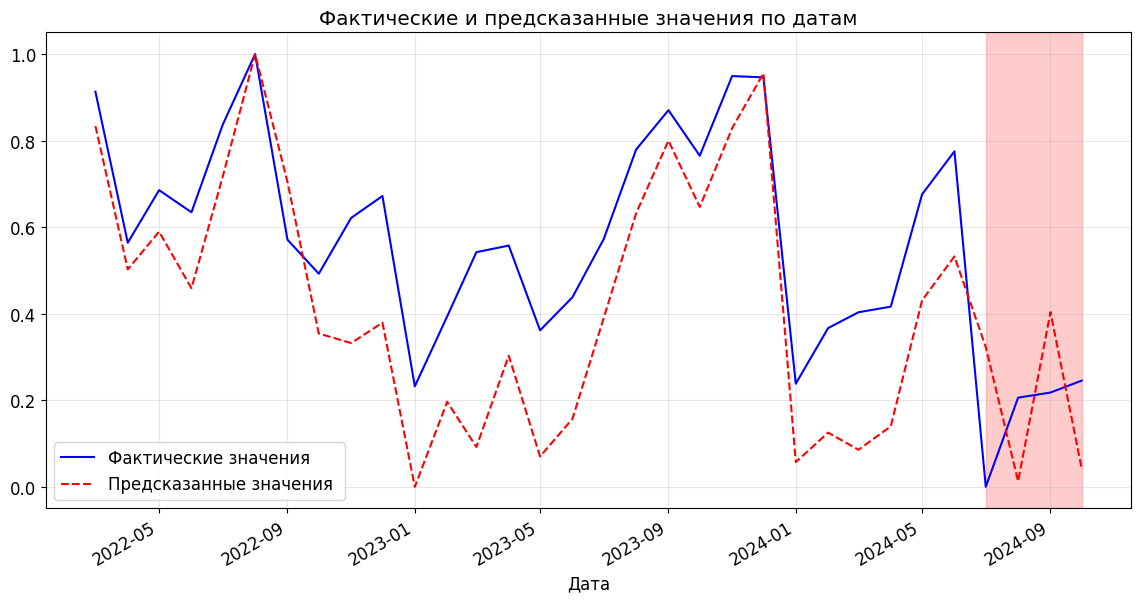

In [305]:
# –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
for_lin['mean_target_norm'] = (for_lin['mean_target'] - for_lin['mean_target'].min()) / \
                              (for_lin['mean_target'].max() - for_lin['mean_target'].min())
for_lin['mean_predict_norm'] = (for_lin['mean_predict'] - for_lin['mean_predict'].min()) / \
                               (for_lin['mean_predict'].max() - for_lin['mean_predict'].min())

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(14, 7))
plt.plot(for_lin['report_date'], for_lin['mean_target_norm'], 
         color='blue', label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.plot(for_lin['report_date'], for_lin['mean_predict_norm'], 
         color='red', linestyle='--', label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è ')

# –í—ã–¥–µ–ª–µ–Ω–∏–µ —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –ø–µ—Ä–∏–æ–¥–∞
test_dates = for_lin[for_lin['split_type'] == 'oot']['report_date']
if not test_dates.empty:
    plt.axvspan(test_dates.min(), test_dates.max(), color='red', alpha=0.2)

plt.title('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –¥–∞—Ç–∞–º')
plt.xlabel('–î–∞—Ç–∞')
plt.ylim(-0.05, 1.05)  # –î–æ–±–∞–≤–ª—è–µ–º –Ω–µ–±–æ–ª—å—à–∏–µ –æ—Ç—Å—Ç—É–ø—ã
plt.grid(True, alpha=0.3)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

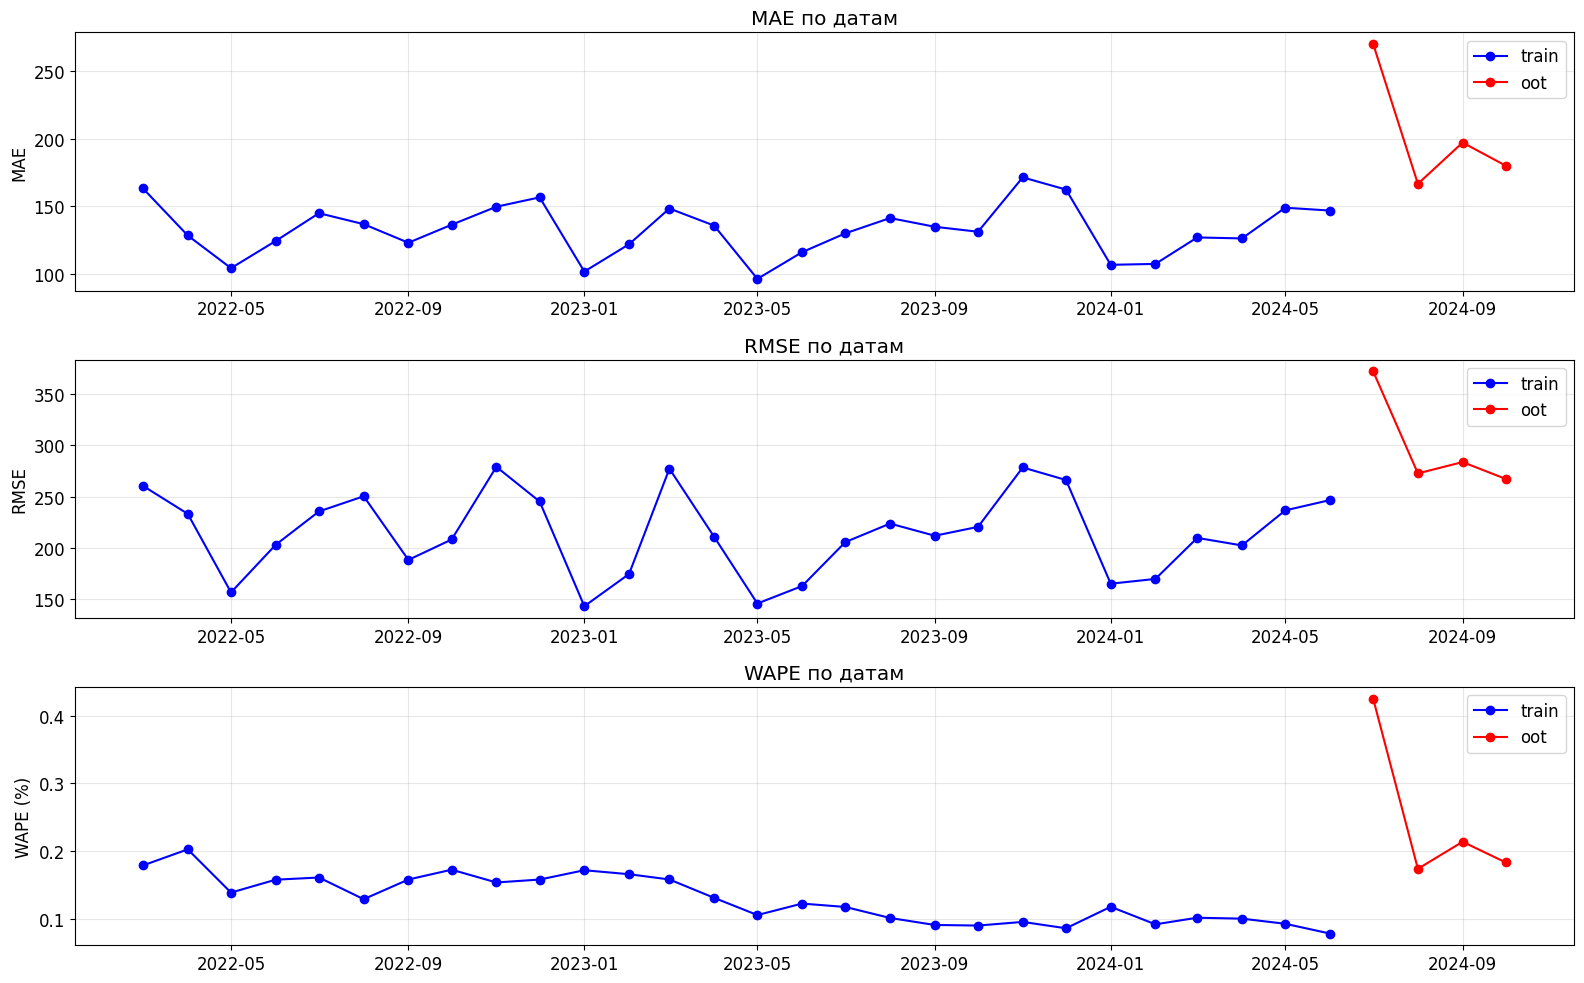

In [285]:
# –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –æ—à–∏–±–∫–∏
plot_df['abs_error'] = np.abs(plot_df['target_area'] - plot_df['final_area'])
plot_df['squared_error'] = (plot_df['target_area'] - plot_df['final_area'])**2

# –ì—Ä—É–ø–ø–∏—Ä—É–µ–º –ø–æ –¥–∞—Ç–∞–º –∏ split_type
metrics = plot_df.groupby(['report_date', 'split_type']).agg({
    'abs_error': 'mean',
    'squared_error': lambda x: np.sqrt(x.mean()),
    'target_area': 'sum'
}).reset_index()
metrics.rename(columns={'abs_error': 'MAE', 'squared_error': 'RMSE'}, inplace=True)
metrics['WAPE'] = metrics['MAE'] / metrics['target_area'] * 100

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ
plt.figure(figsize=(16, 10))

for i, metric in enumerate(['MAE', 'RMSE', 'WAPE'], 1):
    plt.subplot(3, 1, i)
    for split, color in zip(['train', 'oot'], ['blue', 'red']):
        subset = metrics[metrics['split_type'] == split]
        plt.plot(subset['report_date'], subset[metric], 'o-', color=color, label=split)
    
    plt.title(f'{metric} –ø–æ –¥–∞—Ç–∞–º')
    plt.ylabel(metric + (' (%)' if metric == 'WAPE' else ''))
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

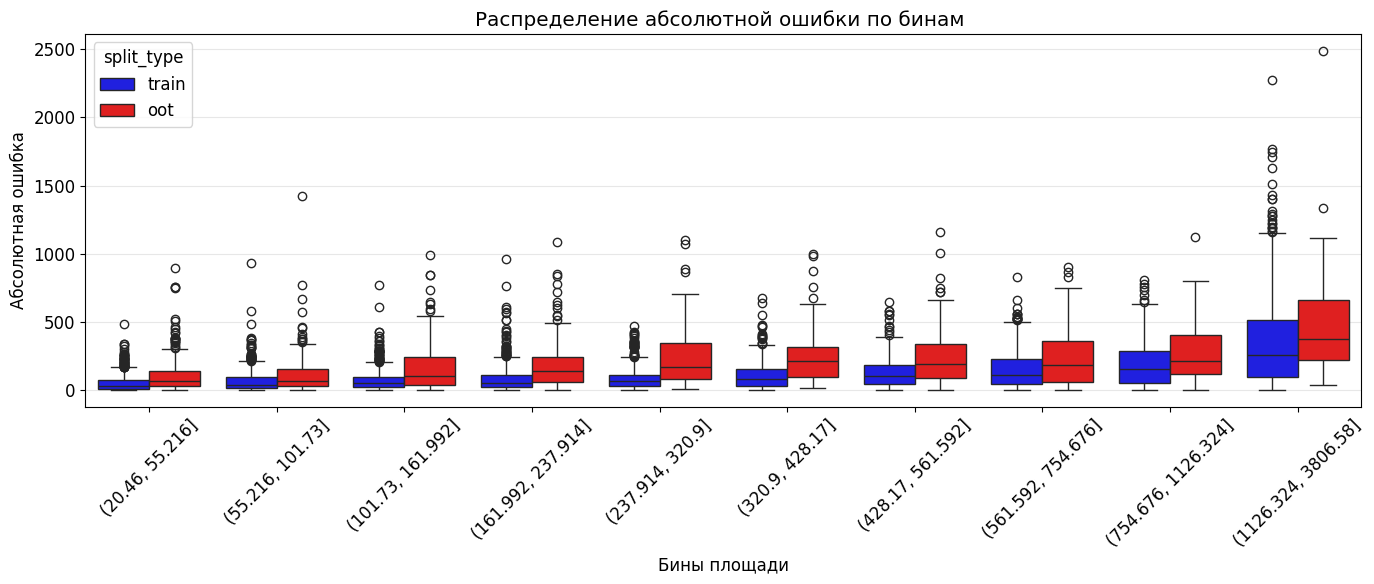

In [293]:
# 1. –°–æ–∑–¥–∞–µ–º –±–∏–Ω—ã –ø–æ –∫–≤–∞–Ω—Ç–∏–ª—è–º
bins = plot_df['target_area'].quantile(np.linspace(0, 1, 11)).unique()
plot_df['area_bin'] = pd.cut(plot_df['target_area'], bins=bins)

# 2. –§–∏–ª—å—Ç—Ä—É–µ–º —Ä–µ–¥–∫–∏–µ –±–∏–Ω—ã
min_oot = 3  # –ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ OOT-–Ω–∞–±–ª—é–¥–µ–Ω–∏–π
valid_bins = plot_df[plot_df['split_type'] == 'oot'].groupby('area_bin').filter(lambda x: len(x) >= min_oot)['area_bin'].unique()
filtered_df = plot_df[plot_df['area_bin'].isin(valid_bins)]

# 3. –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫
plt.figure(figsize=(14, 6))
sns.boxplot(
    x='area_bin',
    y='abs_error',
    hue='split_type',
    data=filtered_df,
    palette={'train': 'blue', 'val': 'green', 'oot': 'red'},
    order=sorted(valid_bins)
)

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–π –æ—à–∏–±–∫–∏ –ø–æ –±–∏–Ω–∞–º ')
plt.xlabel('–ë–∏–Ω—ã –ø–ª–æ—â–∞–¥–∏')
plt.ylabel('–ê–±—Å–æ–ª—é—Ç–Ω–∞—è –æ—à–∏–±–∫–∞')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()